In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from tqdm import tqdm
import os
import pickle
from sklearn.model_selection import train_test_split
import pdb
import datetime
from scipy.stats import pearsonr
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
import matplotlib
from pprint import pprint
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import tensorflow as tf
from tensorflow import keras

import os
import tempfile
import matplotlib as mpl
import sklearn
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict

plt.style.use('fivethirtyeight')

# Defining all Necessary Functions

In [2]:
def visualise_confusion_matrix(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['White','Ransom'])
    ax.yaxis.set_ticklabels(['White','Ransom'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

# guess random class
def random_guess():
    if np.random.rand() < 0.5:
        return 0
    return 1

def holiday_range(df):
    cal = calendar()
    holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())
    df['is_close_to_holiday'] = (df['temp_date_plus7'].isin(holidays) | df['temp_date_minus7'].isin(holidays))
    df.drop(['temp_date_plus7', 'temp_date_minus7'],axis=1,inplace=True)
    return df

def sigmoid(x):
    #returns the logistic function of x
    return 1 / (1 + np.exp(-x))

#method to print better looking plots

def pretty_importances_plot(importances, feature_name, fig_size = (10, 7), xlabel = '', ylabel = '', horizontal_label = None, n_elements=None):
    '''
    This function plots a better looking importances-plot
    
    importances: Occurences of feature_name
    feature_name: unique feature_name
    fig_size: size of plot
    xlabel: xlabel
    ylabel: ylabel
    horizontal_label: Bigger label at the top-left
    n_elements: number of elements to display
    '''
    
    # This code has been borrowed from:
    # https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
    # Credits to SIMONE CENTELLEGHER

    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'

    # percentages = pd.Series(data= list(map(operator.itemgetter(1), word_importances_title_entity)),
    #                       index = list(map(operator.itemgetter(0), word_importances_title_entity)))
    
    if not n_elements:
        n_elements = len(importances)
    
    percentages = pd.Series(
        data = importances[:n_elements],
        index = feature_name[:n_elements]
    )

    df = pd.DataFrame({'percentage' : percentages})
    df = df.sort_values(by='percentage')

    # we first need a numeric placeholder for the y axis
    my_range=list(range(1,len(df.index)+1))

    #fig, ax = plt.subplots(figsize=(5,3.5)) ######################
    fig, ax = plt.subplots(figsize=fig_size)


    # create for each expense type an horizontal line that starts at x = 0 with the length 
    # represented by the specific expense percentage value.
    plt.hlines(y=my_range, xmin=0, xmax=df['percentage'], color='#007ACC', alpha=0.2, linewidth=5)

    # create for each expense type a dot at the level of the expense percentage value
    plt.plot(df['percentage'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

    # set labels
    ax.set_xlabel(xlabel, fontsize=15, fontweight='black', color = '#333F4B')
    ax.set_ylabel(ylabel)
    
     # set axis
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.yticks(my_range, df.index)

    # add an horizonal label for the y axis
    if horizontal_label:
        fig.text(-0.23, 0.96, horizontal_label, fontsize=15, fontweight='black', color = '#333F4B')

    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
#     ax.spines['left'].set_smart_bounds(True)
#     ax.spines['bottom'].set_smart_bounds(True)

    # set the spines position
    ax.spines['bottom'].set_position(('axes', -0.04))
    ax.spines['left'].set_position(('axes', 0.015))
    
class StackingClassifierTree():
    '''
    Custom implementation of Stacking classifier as a little
    more flexiblity with the code is needed.
    '''
    
    def __init__(self, rf_clf, gbdt_clf, C=1.0):
        #get the hyper-param and initialize the model
        self.C = C
        self.rf_clf = rf_clf
        self.gbdt_clf = gbdt_clf
        self.stacking_clf_tree = LogisticRegression(
            C = self.C,
            n_jobs = -1,
            class_weight = 'balanced',
            random_state = 42
            )
        
    def fit(self, X, y):
        #fit the model
        self.stacking_clf_tree.fit(
            pd.DataFrame([
                self.rf_clf.predict(X),
                self.gbdt_clf.predict(X)
            ]).T,
            y_train
            )
        
    def predict(self, x):
        #return predictions
        rf_preds = self.rf_clf.predict(x)
        gbdt_preds = self.gbdt_clf.predict(x)
        
        return self.stacking_clf_tree.predict(
                pd.DataFrame([
                    rf_preds,
                    gbdt_preds
                ]).T
            )
    
class FinalStackedClassifier():
    '''
    Custom implementation of the meta classifier.
    This class stacks both tree-based and distance-based models
    to give the best possibile predictions.
    '''
    def __init__(self, loss):
        #get loss and initialize classifier
        
        self.loss = loss
        self.final_stacked_clf = SGDClassifier(
                        loss = self.loss,
                        penalty = 'elasticnet',
                        n_jobs = -1,
                        random_state = 42,
                        class_weight = 'balanced'
                    )
        
    def fit(self, X_distance, X_tree, y):
        #fit the classifier
        
        self.distance_pred = stacking_clf_distance.predict(X_distance)
        self.tree_pred = stack_clf_tree.predict(X_tree)
        
        self.final_stacked_clf.fit(
            pd.DataFrame([
                self.distance_pred,
                self.tree_pred
            ]).T,
            y
        )
        return True
        
    def predict(self, X_distance, X_tree):
        #return predictions
        
        self.distance_pred = stacking_clf_distance.predict(X_distance)
        self.tree_pred = stack_clf_tree.predict(X_tree)
        
        return self.final_stacked_clf.predict(
                pd.DataFrame([
                    self.distance_pred,
                    self.tree_pred
                ]).T
            )

# Loading dataset and view the first few rows:

In [3]:
file_path = 'BitcoinHeistData.csv'
data = pd.read_csv(file_path)
data.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


## Initial look at data 


In [4]:
data.label.loc[data.label=='white']= 0
data.label.loc[data.label!=0]= 1

print('Number of white (non-ransomware) datapoints: {}\nNumber of ransomware datapoints: {}'\
      .format(data.label.value_counts()[0] , sum(data.label.value_counts()[1:])))
print('Percentage of data-points belonging to ransomware class: {}'.format((sum(data.label) / len(data.label)) * 100))

C:\Users\tnezhad\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Number of white (non-ransomware) datapoints: 2875284
Number of ransomware datapoints: 41413
Percentage of data-points belonging to ransomware class: 1.4198595191752863


In [5]:
data.label=data.label.astype(int)
data.isnull().sum()
data = data.drop_duplicates()

There are not any missing values in any of the attributes or duplicate entries.

## Constructing new features

In [6]:
n_addresses=list(data.address.value_counts())
print('An address is repeated an average of {} number of times'.format(np.mean(n_addresses)))
n_addresses = np.sort(np.array(n_addresses))

An address is repeated an average of 1.108548722109996 number of times


In [7]:
unique_address_data = data.groupby('address').size().to_frame('n_address')
data = data.merge(unique_address_data, on=['address'], how='left').set_index(data.index)
data['n_address'] = boxcox(np.array(list(data['n_address'])))[0]

In [8]:
data['temp_date'] = data['year'].astype(str) + "-" + data['day'].astype(str)
data['Date'] = pd.to_datetime(data['temp_date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%j").strftime("%Y-%m-%d")))
data['day_of_week'] = data['Date'].dt.weekday
data.drop(['temp_date'],axis=1,inplace=True)

In [9]:
# using the quarter property
data['quarter_number'] = data['Date'].dt.quarter

data['temp_date_plus7'] = data['Date'] + datetime.timedelta(7)
data['temp_date_minus7'] = data['Date'] - datetime.timedelta(7)

data = data.groupby('year').apply(holiday_range)
data.drop(['Date'], axis=1, inplace=True)

In [10]:
data['gaussian_length'] = boxcox((np.sin(np.log(np.sqrt(np.array(data['length']) + 1e-6)))) ** 2)[0]
data['gaussian_weight'] = np.array(boxcox(np.array(data['weight'],  dtype=np.longdouble))[0])
data['log_count'] = np.log(np.array(data['count']) + 1e-6)

C:\Users\tnezhad\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [11]:
data['sigmoid_looped'] = sigmoid(np.array(data['looped']))
data['gaussian_neighbors'] = boxcox(np.array(data['neighbors']) + 1e-6)[0]
data['gaussian_income'] = boxcox(np.array(data['income']) + 1e-6)[0]

In [12]:
median_length = np.median(data['length'])
median_weight = np.median(data['weight'])
data['interaction_length_weight'] = 2

data['interaction_length_weight'][data.index[(data['length'] > median_length) & (data['weight'] > median_weight)]] = 0
data['interaction_length_weight'][data.index[(data['length'] > median_length) & (data['weight'] <= median_weight)]] = 1


C:\Users\tnezhad\AppData\Local\Temp/ipykernel_19824/1104337686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['interaction_length_weight'][data.index[(data['length'] > median_length) & (data['weight'] > median_weight)]] = 0
C:\Users\tnezhad\AppData\Local\Temp/ipykernel_19824/1104337686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['interaction_length_weight'][data.index[(data['length'] > median_length) & (data['weight'] <= median_weight)]] = 1


In [13]:
median_count = np.median(data['log_count'])
median_income = np.median(data['gaussian_income'])
data['interaction_count_income'] = 2

data['interaction_count_income'][data.index[(data['log_count'] > median_count) & (data['gaussian_income'] > median_income)]] = 0
data['interaction_count_income'][data.index[(data['log_count'] > median_count) & (data['gaussian_income'] <= median_income)]] = 1


C:\Users\tnezhad\AppData\Local\Temp/ipykernel_19824/3876246134.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['interaction_count_income'][data.index[(data['log_count'] > median_count) & (data['gaussian_income'] > median_income)]] = 0
C:\Users\tnezhad\AppData\Local\Temp/ipykernel_19824/3876246134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['interaction_count_income'][data.index[(data['log_count'] > median_count) & (data['gaussian_income'] <= median_income)]] = 1


## Data Preparation for Modeling

In [14]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [16]:
#Split Data to test and train
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), 
    data.label,
    stratify = data.label, #Having equal number of positive class in both training and testing
    random_state = 42,
    test_size = 0.2
)

#storing the stock dataframes for later use
X_train_stock = X_train.copy()
X_test_stock = X_test.copy()
X_train_stock = X_train_stock[main_col] 
X_test_stock = X_test_stock[main_col] 

main_col = [
    'year',
    'day',
    'length',
    'weight',
    'count',
    'looped',
    'neighbors',
    'income'
]

### Preparing Data For ML Models

In [45]:
X_train_model, X_test_model = X_train.drop(['address'], axis=1).to_numpy(), X_test.drop(['address'], axis=1).to_numpy()

In [46]:
scaler = StandardScaler()
train_features = scaler.fit_transform(X_train_model)

test_features = scaler.transform(X_test_model)

train_features = np.clip(train_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (2333357,)
Test labels shape: (583340,)
Training features shape: (2333357, 20)
Test features shape: (583340, 20)


### Pair plots
Pairs plots let us see how points in a feature are distributed with respect to other features.

### Correlations
Correlation is a term that is a measure of the strength of a linear relationship between two quantitative variables (e.g., height, weight).

In [17]:
corr = X_train.corr()
corr

,year,day,length,weight,count,looped,neighbors,income,n_address,day_of_week,quarter_number,is_close_to_holiday,gaussian_length,gaussian_weight,log_count,sigmoid_looped,gaussian_neighbors,gaussian_income,interaction_length_weight,interaction_count_income
year,1.000000,-4.031641e-02,0.163223,0.011742,0.285714,0.113152,-0.001148,-0.021044,-0.211150,-0.002276,-0.034407,-0.000989,-0.067477,0.115096,0.148971,0.025569,7.791237e-02,-0.282406,-0.085703,0.027218
day,-0.040316,1.000000e+00,0.011836,0.000928,-0.002269,0.002954,0.000185,0.002973,-0.010550,0.001221,0.967551,0.037579,-0.004481,-0.008055,0.009084,-0.003534,3.329651e-08,-0.022639,-0.000413,-0.005764
length,0.163223,1.183619e-02,1.000000,0.000665,0.703332,0.411354,0.031472,0.000539,-0.095459,-0.027603,0.007843,0.009060,0.020996,-0.355195,0.902035,0.471085,2.325420e-01,-0.016204,-0.657991,-0.582044
weight,0.011742,9.282071e-04,0.000665,1.000000,0.023062,0.062714,0.680173,0.072098,0.048038,0.003279,0.001275,-0.001019,-0.030778,0.224255,0.015996,0.055089,1.040196e-01,0.054844,-0.035224,-0.039916
count,0.285714,-2.268535e-03,0.703332,0.023062,1.000000,0.559790,0.025378,-0.003888,-0.055582,-0.049389,-0.005696,0.012383,-0.105760,-0.119158,0.797897,0.376559,1.227292e-01,-0.052043,-0.404339,-0.430311
looped,0.113152,2.954478e-03,0.411354,0.062714,0.559790,1.000000,0.052801,0.002275,-0.009462,-0.031976,-0.000458,0.007275,-0.064367,-0.074751,0.459501,0.664493,1.764438e-01,0.020768,-0.235004,-0.277160
neighbors,-0.001148,1.854476e-04,0.031472,0.680173,0.025378,0.052801,1.000000,0.139024,0.046857,0.000838,0.000094,-0.000717,-0.004957,0.089631,0.035469,0.070104,1.344205e-01,0.050440,-0.038408,-0.047009
income,-0.021044,2.973484e-03,0.000539,0.072098,-0.003888,0.002275,0.139024,1.000000,0.000456,-0.001647,0.002415,-0.000737,0.006540,0.001094,-0.004129,0.003340,1.749685e-02,0.058314,-0.005089,-0.004997
n_address,-0.211150,-1.055004e-02,-0.095459,0.048038,-0.055582,-0.009462,0.046857,0.000456,1.000000,0.003972,-0.010871,-0.002163,-0.070905,0.001574,-0.017393,0.029143,-7.104606e-02,-0.020273,0.060042,-0.092530
day_of_week,-0.002276,1.221304e-03,-0.027603,0.003279,-0.049389,-0.031976,0.000838,-0.001647,0.003972,1.000000,-0.000030,-0.233032,0.006651,0.016421,-0.032149,-0.006812,-6.838552e-03,-0.005415,0.006502,0.017723


### Correlation map
Correlation map shows how correlated sets of features are. Darker the color in the box, higher is the correlation between the corresponding features

<AxesSubplot:>

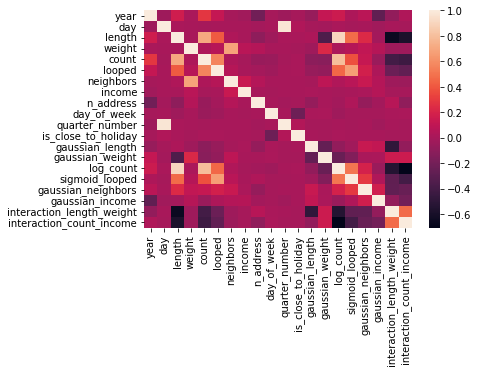

In [18]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Modeling

### Metrics
Key Performance Indicator : Recall

Recall tells us of all the data-points in the data-set that are actually positive, what percentage of them have we predicted to be positive.
### Why?
We want to correctly classify as many positive data-points (ransomware transactions) as possible even if it means we incorreclty classify a few white transactions to be of type ransomware also. A domain expert can validate our results and filter out the false positives. We want maximum recall.
### Other metrics:
Log-loss: A loss function that has no specific range. Lower is better.
Precision: Tells us what percentage of data-points that we classified as positive, are infact positive. Higher is better.
ROCAUC: Uses True Positive Rate and False Positive Rate to get area under the curve. Higher is better.
F1-Score: Harmonic mean of precision and recall. Higher is better.
Accuracy: Tells us how accurate our predictions are. Higher is better

## Modelling - Distance based models
Distance-based models are based on the geometry of data. As the name implies, distance-based models work on the concept of distance.
###  Logistic Regression
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

In [33]:
data.head()

,address,year,day,length,weight,count,looped,neighbors,income,label,...,quarter_number,is_close_to_holiday,gaussian_length,gaussian_weight,log_count,sigmoid_looped,gaussian_neighbors,gaussian_income,interaction_length_weight,interaction_count_income
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,1,...,1,False,-0.015776,-3.193848,9.999995e-07,0.5,5.841922e-01,4.117890,1,2
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,1,...,2,False,-0.103159,-4.281714,9.999995e-07,0.5,9.999992e-07,4.117884,1,2
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,1,...,3,False,-0.895270,0.000000,9.999995e-07,0.5,5.841922e-01,4.125572,2,2
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,1,...,4,True,-0.321544,-3.489562,9.999995e-07,0.5,5.841922e-01,4.113622,1,2
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,1,...,3,False,-0.835088,-2.082769,6.122493e+00,0.5,9.999992e-07,4.125572,1,0


In [35]:
x = data.drop(['label', 'address'], axis=1)
y = data['label']

In [30]:
lr_model = SGDClassifier(
    alpha = 0.001,
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

In [147]:
auc_cv_score = cross_val_score(lr_model, train_features, y_train, cv=5, scoring='roc_auc')
y_pred_oos = cross_val_predict(lr_model, train_features, y_train, cv=5)
y_pred_proba_oos = cross_val_predict(lr_model, train_features, y_train, cv=5, method='predict_proba')
lr_model.fit(train_features, y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

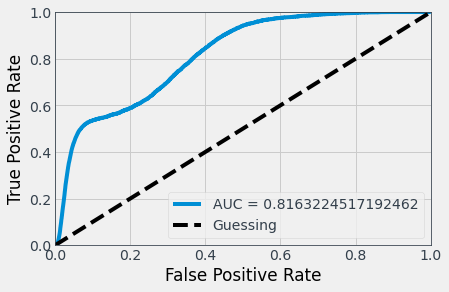

{'fpr': array([0.00000000e+00, 1.73895805e-06, 2.02588613e-03, ...,
        9.98923585e-01, 9.98927063e-01, 1.00000000e+00]),
 'tpr': array([0., 0., 0., ..., 1., 1., 1.]),
 'threshold': array([1.98945094, 0.98945094, 0.96704726, ..., 0.02035252, 0.02034527,
        0.0022821 ])}

In [149]:
y_pred_lr = lr_model.predict(test_features)
y_pred_proba_lr = lr_model.predict_proba(test_features)
plot_roc_curve(y_pred_proba_lr[:, 1], y_test, show_graph=True)

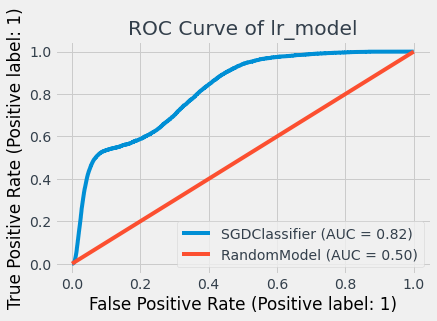

In [163]:
plot_roc_curve(
    lr_model,
    test_features,
    y_test
)
plt.title('ROC Curve of lr_model')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
plt.legend()
plt.show()

In [179]:
# #displaying the table
result_table = PrettyTable()
result_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

result_table.add_row([
    'lr_model',
    np.round(accuracy_score(y_true = y_test, y_pred = y_pred_lr), 2),
    np.round(f1_score(y_true = y_test, y_pred = y_pred_lr), 2),
    np.round(precision_score(y_true = y_test, y_pred = y_pred_lr),2),
    np.round(recall_score(y_true = y_test, y_pred = y_pred_lr),2),
    np.round(log_loss(y_true = y_test, y_pred = y_pred_lr), 2)
])

print(result_table)

+------------+----------+----------+-----------+--------+----------+
| Model Name | Accuracy | F1-Score | Precision | Recall | Log-loss |
+------------+----------+----------+-----------+--------+----------+
|  lr_model  |   0.75   |   0.07   |    0.04   |  0.63  |   8.59   |
+------------+----------+----------+-----------+--------+----------+


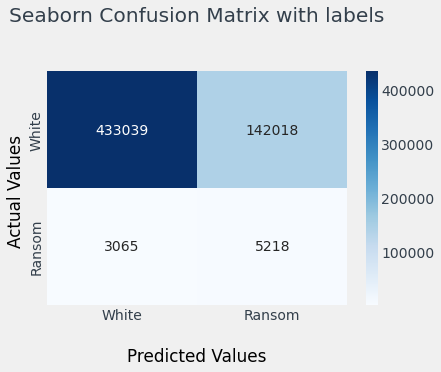

In [154]:
visualise_confusion_matrix(y_test, y_pred_lr)

In [194]:
features_name = X_train.drop(['address'], axis=1).columns
features_name

Index(['year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors',
       'income', 'n_address', 'day_of_week', 'quarter_number',
       'is_close_to_holiday', 'gaussian_length', 'gaussian_weight',
       'log_count', 'sigmoid_looped', 'gaussian_neighbors', 'gaussian_income',
       'interaction_length_weight', 'interaction_count_income'],
      dtype='object')

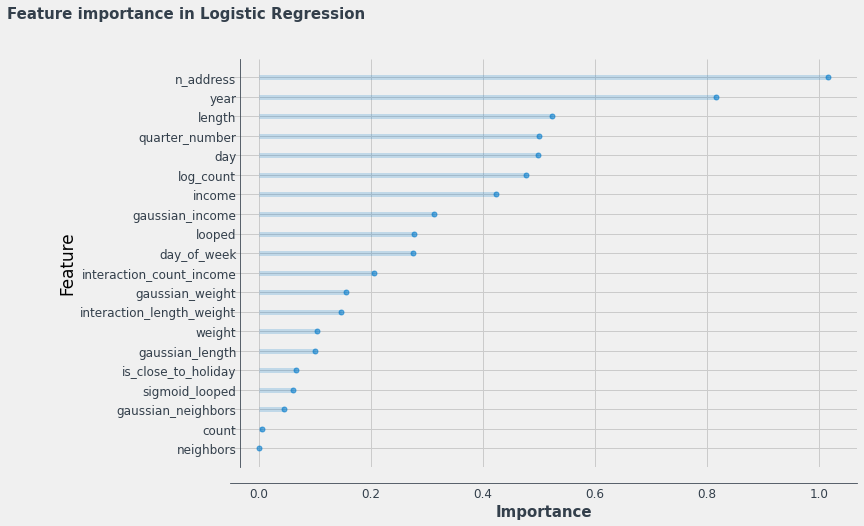

In [196]:
#Feauture importance tells us what the role each feature plays in predicting the target variable
pretty_importances_plot(
    np.abs(lr_model.coef_[0]), 
    feature_name= features_name,
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in Logistic Regression'
)

In [ ]:
features = ['INVENTORY', 'DAYS', 'RMSE', 'R2', 'AVG_POS_AMT', 'AVG_INVENTORY',
       'AVG_PRICE', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13']
feat_imp = pd.Series(GBC_trainer.feature_importances_, features).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as graph
sns.displot(df_feature, x='score', hue='LABEL')
graph.show()

### Support vector machines
The support-vector clustering algorithm, created by Hava Siegelmann and Vladimir Vapnik, applies the statistics of support vectors, developed in the support vector machines algorithm, to categorize unlabeled data, and is one of the most widely used clustering algorithms in industrial applications.

In [54]:
#fitting the model
svc_model = SGDClassifier(
    loss = 'hinge',
    n_jobs = -1,
    alpha = 0.1, # alpha = 1/C and our best C = 10
    penalty = 'elasticnet',
    random_state = 42,
    class_weight = 'balanced'
)

In [92]:
auc_cv_score = cross_val_score(svc_model, train_features, y_train, cv=5, scoring='roc_auc')
y_pred_oos_svc = cross_val_predict(svc_model, train_features, y_train, cv=5)

In [93]:
y_pred_proba_oos_svc = cross_val_predict(svc_model, train_features, y_train, cv=5, method='predict_proba')
svc_model.fit(train_features, y_train)
# Out-of-sample metrics
# roc_auc_total = metrics.roc_auc_score(y_train, y_pred_proba_oos_svc[:, 1])
accuracy = metrics.accuracy_score(y_train, y_pred_oos_svc)

print(f'Accuracy OOS = {metrics.accuracy_score(y_train, y_pred_oos_svc):.3f}')
print(f'AUC Score Mean and Std : μ = {auc_cv_score.mean():.3f}, σ = {auc_cv_score.std():.3f}')
print(f'FScore OOS = {metrics.f1_score(y_train, y_pred_oos_svc):.3f}')
y_pred_svc = svc_model.predict(test_features)

Accuracy OOS = 0.870
AUC Score Mean and Std : μ = 0.826, σ = 0.003
FScore OOS = 0.109


In [180]:
result_table.add_row([
    'SVC_model',
    np.round(accuracy_score(y_true = y_test, y_pred = y_pred_svc), 2),
    np.round(f1_score(y_true = y_test, y_pred = y_pred_svc), 2),
    np.round(precision_score(y_true = y_test, y_pred = y_pred_svc),2),
    np.round(recall_score(y_true = y_test, y_pred = y_pred_svc),2),
    np.round(log_loss(y_true = y_test, y_pred = y_pred_svc), 2)
])

print(result_table)

+------------+----------+----------+-----------+--------+----------+
| Model Name | Accuracy | F1-Score | Precision | Recall | Log-loss |
+------------+----------+----------+-----------+--------+----------+
|  lr_model  |   0.75   |   0.07   |    0.04   |  0.63  |   8.59   |
| SVC_model  |   0.87   |   0.11   |    0.06   |  0.55  |   4.46   |
+------------+----------+----------+-----------+--------+----------+


C:\Users\tnezhad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


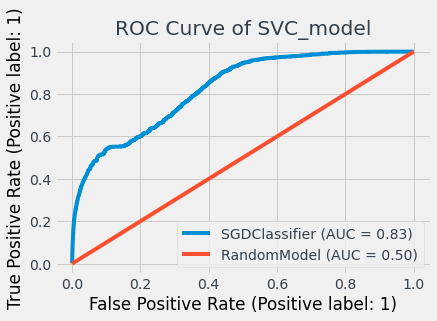

In [166]:
plot_roc_curve(
    svc_model,
    test_features,
    y_test
)
plt.title('ROC Curve of SVC_model')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
plt.legend()
plt.show()

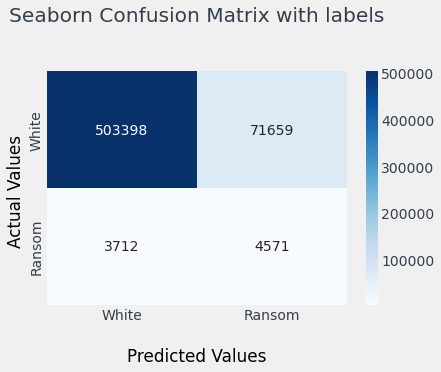

In [102]:
visualise_confusion_matrix(y_test, y_pred_svc)

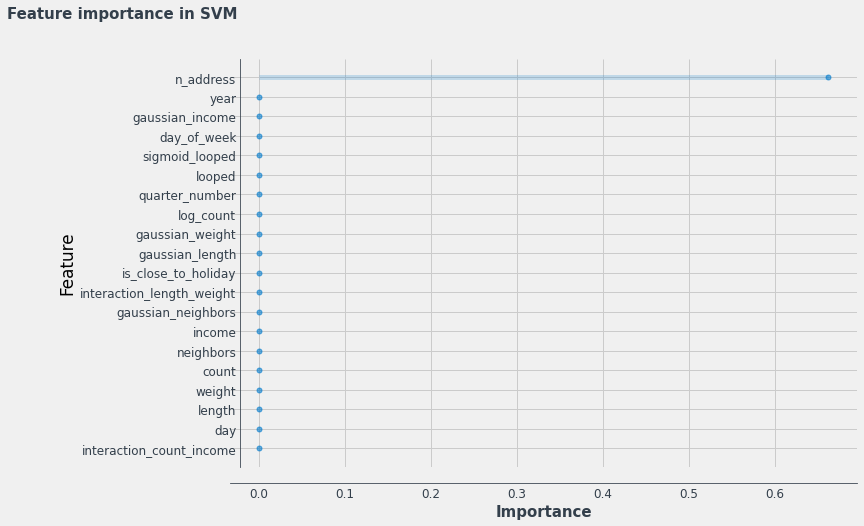

In [197]:
pretty_importances_plot(
    np.abs(svc_model.coef_[0]), 
    feature_name= features_name,
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in SVM'
)

## Modelling - Tree based models
Tree based models are a family of classifiers which form a tree with each attribute at one level and which perform series of condition checking with one attribute at a time

### Random Forest Classifier

In [97]:
rf_model = RandomForestClassifier(
    n_estimators = 500,
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
)

In [98]:
auc_cv_score = cross_val_score(rf_model, train_features, y_train, cv=5, scoring='roc_auc')
y_pred_oos_rf = cross_val_predict(rf_model, train_features, y_train, cv=5)
y_pred_proba_oos_rf = cross_val_predict(rf_model, train_features, y_train, cv=5, method='predict_proba')
rf_model.fit(train_features, y_train)
# Out-of-sample metrics
roc_auc_total = metrics.roc_auc_score(y_train, y_pred_proba_oos_rf[:, 1])
accuracy = metrics.accuracy_score(y_train, y_pred_oos_rf)

print(f'Accuracy OOS = {metrics.accuracy_score(y_train, y_pred_oos_rf):.3f}')
print(f'AUC Score Mean and Std : μ = {auc_cv_score.mean():.3f}, σ = {auc_cv_score.std():.3f}')
print(f'FScore OOS = {metrics.f1_score(y_train, y_pred_oos_rf):.3f}')

Accuracy OOS = 0.993
AUC Score Mean and Std : μ = 0.984, σ = 0.001
FScore OOS = 0.721


In [181]:
y_pred_rf = rf_model.predict(test_features)

result_table.add_row([
    'rf_model',
    np.round(accuracy_score(y_true = y_test, y_pred = y_pred_rf), 2),
    np.round(f1_score(y_true = y_test, y_pred = y_pred_rf), 2),
    np.round(precision_score(y_true = y_test, y_pred = y_pred_rf),2),
    np.round(recall_score(y_true = y_test, y_pred = y_pred_rf),2),
    np.round(log_loss(y_true = y_test, y_pred = y_pred_rf), 2)
])

print(result_table)

+------------+----------+----------+-----------+--------+----------+
| Model Name | Accuracy | F1-Score | Precision | Recall | Log-loss |
+------------+----------+----------+-----------+--------+----------+
|  lr_model  |   0.75   |   0.07   |    0.04   |  0.63  |   8.59   |
| SVC_model  |   0.87   |   0.11   |    0.06   |  0.55  |   4.46   |
|  rf_model  |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
+------------+----------+----------+-----------+--------+----------+


C:\Users\tnezhad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


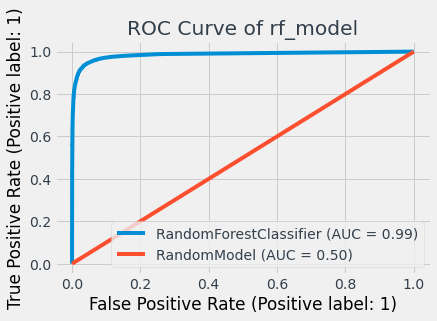

In [168]:
plot_roc_curve(
    rf_model,
    test_features,
    y_test
)
plt.title('ROC Curve of rf_model')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
plt.legend()
plt.show()

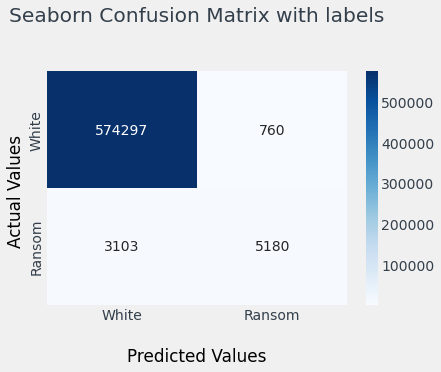

In [101]:
visualise_confusion_matrix(y_test, y_pred_rf)

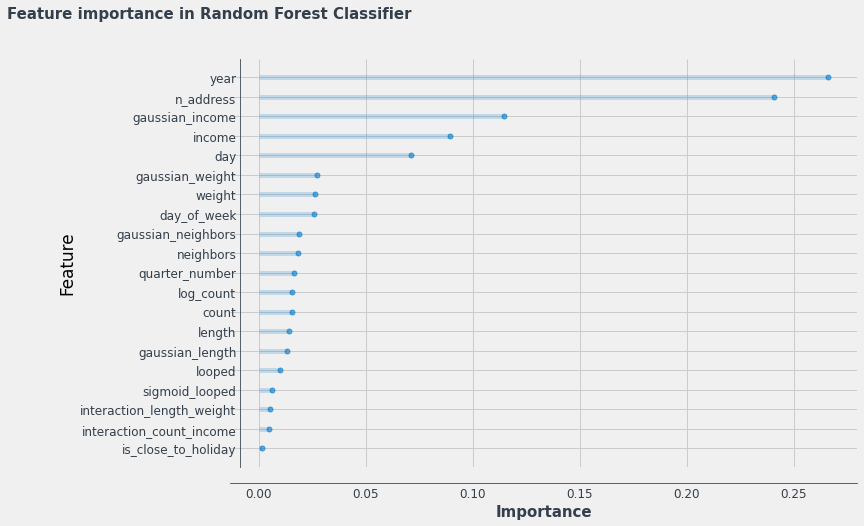

In [198]:
#displaying feature importances
pretty_importances_plot(
    rf_model.feature_importances_, 
    feature_name= features_name,
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in Random Forest Classifier'
)

### Gradient Boosted Decision Trees


In [56]:
#we use counter to get an esimator as to how much 
#weight should be given to positive class

counter = Counter(y_train)
estimate = counter[0] / counter[1]

gbdt_model = XGBClassifier(
    n_estimators = 500,
    max_depth = 2,
    verbosity = 1,
    n_jobs = -1,
    random_state = 42,
    scale_pos_weight = estimate
)

In [103]:
auc_cv_score = cross_val_score(gbdt_model, train_features, y_train, cv=5, scoring='roc_auc')
y_pred_oos_gbdt = cross_val_predict(gbdt_model, train_features, y_train, cv=5)
y_pred_proba_oos_gbdt = cross_val_predict(gbdt_model, train_features, y_train, cv=5, method='predict_proba')
gbdt_model.fit(train_features, y_train)
# Out-of-sample metrics
roc_auc_total = metrics.roc_auc_score(y_train, y_pred_proba_oos_gbdt[:, 1])
accuracy = metrics.accuracy_score(y_train, y_pred_oos_gbdt)

print(f'Accuracy OOS = {metrics.accuracy_score(y_train, y_pred_oos_gbdt):.3f}')
print(f'AUC Score Mean and Std : μ = {auc_cv_score.mean():.3f}, σ = {auc_cv_score.std():.3f}')
print(f'FScore OOS = {metrics.f1_score(y_train, y_pred_oos_gbdt):.3f}')

C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:09:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:13:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:21:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:25:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:29:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:33:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:37:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:48:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:52:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\tnezhad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy OOS = 0.933
AUC Score Mean and Std : μ = 0.986, σ = 0.000
FScore OOS = 0.288


In [182]:
# y_pred_gbdt = gbdt_model.predict(test_features)

result_table.add_row([
    'gbdt_model',
    np.round(accuracy_score(y_true = y_test, y_pred = y_pred_gbdt), 2),
    np.round(f1_score(y_true = y_test, y_pred = y_pred_gbdt), 2),
    np.round(precision_score(y_true = y_test, y_pred = y_pred_gbdt),2),
    np.round(recall_score(y_true = y_test, y_pred = y_pred_gbdt),2),
    np.round(log_loss(y_true = y_test, y_pred = y_pred_gbdt), 2)
])

print(result_table)

+------------+----------+----------+-----------+--------+----------+
| Model Name | Accuracy | F1-Score | Precision | Recall | Log-loss |
+------------+----------+----------+-----------+--------+----------+
|  lr_model  |   0.75   |   0.07   |    0.04   |  0.63  |   8.59   |
| SVC_model  |   0.87   |   0.11   |    0.06   |  0.55  |   4.46   |
|  rf_model  |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
| gbdt_model |   0.93   |   0.28   |    0.17   |  0.95  |   2.34   |
+------------+----------+----------+-----------+--------+----------+


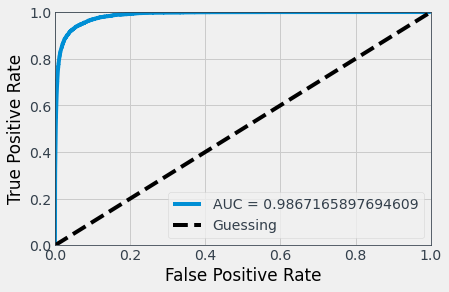

{'fpr': array([0.        , 0.        , 0.        , ..., 0.99998261, 0.99998957,
        1.        ]),
 'tpr': array([0.00000000e+00, 6.03646022e-04, 1.08656284e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'threshold': array([1.9999999e+00, 9.9999988e-01, 9.9999976e-01, ..., 1.1214830e-09,
        1.0952678e-09, 4.4078527e-10], dtype=float32)}

In [111]:
y_pred_proba_gbdt = gbdt_model.predict_proba(test_features)
plot_roc_curve(y_pred_proba_gbdt[:, 1], y_test, show_graph=True)

C:\Users\tnezhad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


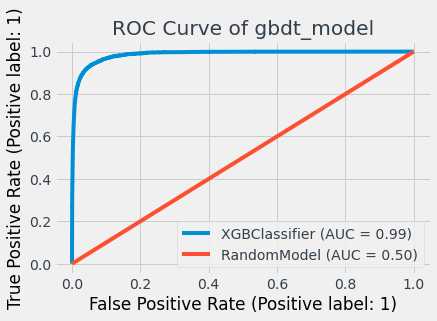

In [170]:
plot_roc_curve(
    gbdt_model,
    test_features,
    y_test
)
plt.title('ROC Curve of gbdt_model')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
plt.legend()
plt.show()

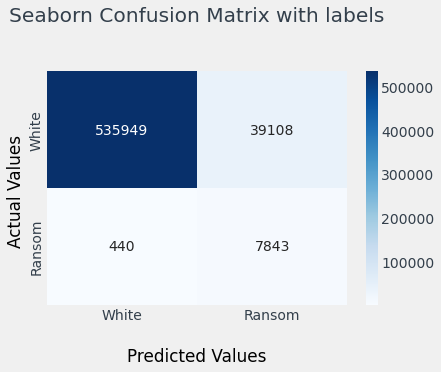

In [106]:
visualise_confusion_matrix(y_test, y_pred_gbdt)

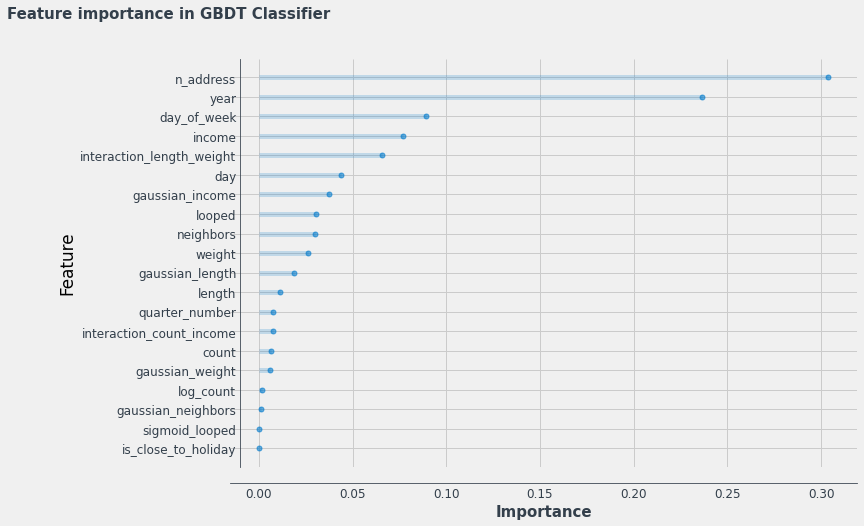

In [199]:
#feature importances
pretty_importances_plot(
    gbdt_model.feature_importances_, 
    feature_name= features_name,
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in GBDT Classifier'
)

## Modelling - Stacking Classifier
* Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [109]:
stack_clf_tree = StackingClassifierTree(rf_model, gbdt_model, C=1)
stack_clf_tree.fit(train_features, y_train)

In [183]:
stack_tree_preds = stack_clf_tree.predict(test_features)

result_table.add_row([
    'stacking_clf',
    np.round(accuracy_score(y_true = y_test, y_pred = stack_tree_preds), 2),
    np.round(f1_score(y_true = y_test, y_pred = stack_tree_preds), 2),
    np.round(precision_score(y_true = y_test, y_pred = stack_tree_preds),2),
    np.round(recall_score(y_true = y_test, y_pred = stack_tree_preds),2),
    np.round(log_loss(y_true = y_test, y_pred = stack_tree_preds), 2)
])

print(result_table)

+--------------+----------+----------+-----------+--------+----------+
|  Model Name  | Accuracy | F1-Score | Precision | Recall | Log-loss |
+--------------+----------+----------+-----------+--------+----------+
|   lr_model   |   0.75   |   0.07   |    0.04   |  0.63  |   8.59   |
|  SVC_model   |   0.87   |   0.11   |    0.06   |  0.55  |   4.46   |
|   rf_model   |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
|  gbdt_model  |   0.93   |   0.28   |    0.17   |  0.95  |   2.34   |
| stacking_clf |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
+--------------+----------+----------+-----------+--------+----------+


# Neural Networks

In [41]:
from rosey_graph import plot_precision, plot_recall, plot_roc_curve

neg, pos = np.bincount(y.astype(int))

total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 2916697
    Positive: 41413 (1.42% of total)



In [43]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.5072015494817207, 1: 35.21475140656316}

### Neural Network -MLPC model

In [ ]:
MLP_model = MLPClassifier()
auc_cv_score = cross_val_score(MLP_model, train_features, y_train, cv=5, scoring='roc_auc')
y_pred_oos = cross_val_predict(MLP_model, train_features, y_train, cv=5)
y_pred_proba_oos = cross_val_predict(MLP_model, train_features, y_train, cv=5, method='predict_proba')
MLP_model.fit(train_features, y_train)

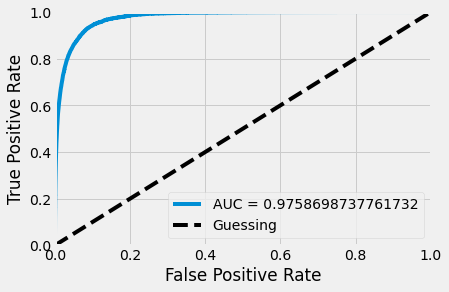

{'fpr': array([0.00000000e+00, 0.00000000e+00, 1.73895805e-06, ...,
        9.95569135e-01, 9.95572613e-01, 1.00000000e+00]),
 'tpr': array([0.00000000e+00, 1.20729204e-04, 1.20729204e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'threshold': array([1.97450139e+00, 9.74501386e-01, 9.72283881e-01, ...,
        9.74287539e-12, 9.73132284e-12, 1.52746193e-33])}

In [61]:
y_pred = MLP_model.predict(test_features)
y_pred_proba = MLP_model.predict_proba(test_features)
plot_roc_curve(y_pred_proba[:, 1], y_test, show_graph=True)

In [184]:
result4_table.add_row([
    'MLP_model',
    np.round(accuracy_score(y_true = y_test, y_pred = y_pred), 2),
    np.round(f1_score(y_true = y_test, y_pred = y_pred), 2),
    np.round(precision_score(y_true = y_test, y_pred = y_pred),2),
    np.round(recall_score(y_true = y_test, y_pred = y_pred),2),
    np.round(log_loss(y_true = y_test, y_pred = y_pred), 2)
])

print(result4_table)

+--------------+----------+----------+-----------+--------+----------+
|  Model Name  | Accuracy | F1-Score | Precision | Recall | Log-loss |
+--------------+----------+----------+-----------+--------+----------+
|   lr_model   |   0.75   |   0.07   |    0.04   |  0.63  |   8.59   |
|  SVC_model   |   0.87   |   0.11   |    0.06   |  0.55  |   4.46   |
|   rf_model   |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
|  gbdt_model  |   0.93   |   0.28   |    0.17   |  0.95  |   2.34   |
| stacking_clf |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
|  MLP_model   |   0.99   |   0.43   |    0.72   |  0.31  |   0.4    |
+--------------+----------+----------+-----------+--------+----------+


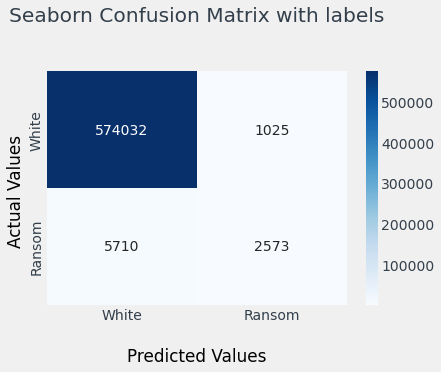

In [201]:
visualise_confusion_matrix(y_test, y_pred)

# Neural Network- Deep Learning

In [65]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [70]:
initial_bias = np.log([pos/neg])
dl_model = make_model(output_bias=initial_bias)
dl_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                336       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [79]:
EPOCHS = 100
BATCH_SIZE = 2048
weighted_history = dl_model.fit(
    train_features,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    class_weight=class_weight)

Epoch 1/100
1140/1140 [==============================] - 4s 2ms/step - loss: 0.8647 - tp: 15370.0000 - fp: 435582.0000 - tn: 1864645.0000 - fn: 17760.0000 - accuracy: 0.8057 - precision: 0.0341 - recall: 0.4639 - auc: 0.7061 - prc: 0.0407
Epoch 2/100
1140/1140 [==============================] - 2s 2ms/step - loss: 0.6224 - tp: 19823.0000 - fp: 456546.0000 - tn: 1843681.0000 - fn: 13307.0000 - accuracy: 0.7986 - precision: 0.0416 - recall: 0.5983 - auc: 0.7968 - prc: 0.0618
Epoch 3/100
1140/1140 [==============================] - 2s 2ms/step - loss: 0.5464 - tp: 21228.0000 - fp: 436570.0000 - tn: 1863657.0000 - fn: 11902.0000 - accuracy: 0.8078 - precision: 0.0464 - recall: 0.6407 - auc: 0.8252 - prc: 0.0739
Epoch 4/100
1140/1140 [==============================] - 2s 2ms/step - loss: 0.4937 - tp: 22641.0000 - fp: 429787.0000 - tn: 1870440.0000 - fn: 10489.0000 - accuracy: 0.8113 - precision: 0.0500 - recall: 0.6834 - auc: 0.8476 - prc: 0.0841
Epoch 5/100
1140/1140 [=====================

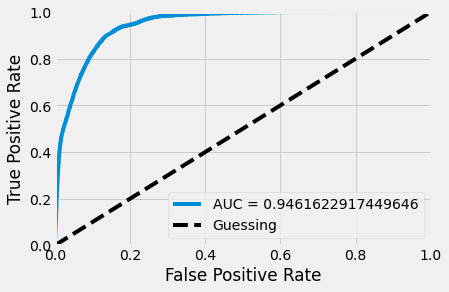

{'fpr': array([0.00000000e+00, 1.73895805e-06, 6.95583220e-06, ...,
        9.99695682e-01, 9.99699160e-01, 1.00000000e+00]),
 'tpr': array([0., 0., 0., ..., 1., 1., 1.]),
 'threshold': array([1.9975923e+00, 9.9759233e-01, 9.9586564e-01, ..., 2.6198089e-13,
        2.5984152e-13, 1.7564608e-23], dtype=float32)}

In [84]:
y_pred_dl = dl_model.predict(test_features, batch_size=BATCH_SIZE)
plot_roc_curve(y_pred_dl, y_test, show_graph=True)

In [185]:
# y_pred_dl_bin = (y_pred_dl > 0.5).astype(int)
result4_table.add_row([
    'DL_model',
    np.round(accuracy_score(y_true = y_test, y_pred = y_pred_dl_bin), 2),
    np.round(f1_score(y_true = y_test, y_pred = y_pred_dl_bin), 2),
    np.round(precision_score(y_true = y_test, y_pred = y_pred_dl_bin),2),
    np.round(recall_score(y_true = y_test, y_pred = y_pred_dl_bin),2),
    np.round(log_loss(y_true = y_test, y_pred = y_pred_dl_bin), 2)
])

print(result4_table)

+--------------+----------+----------+-----------+--------+----------+
|  Model Name  | Accuracy | F1-Score | Precision | Recall | Log-loss |
+--------------+----------+----------+-----------+--------+----------+
|   lr_model   |   0.75   |   0.07   |    0.04   |  0.63  |   8.59   |
|  SVC_model   |   0.87   |   0.11   |    0.06   |  0.55  |   4.46   |
|   rf_model   |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
|  gbdt_model  |   0.93   |   0.28   |    0.17   |  0.95  |   2.34   |
| stacking_clf |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
|  MLP_model   |   0.99   |   0.43   |    0.72   |  0.31  |   0.4    |
|   DL_model   |   0.83   |   0.13   |    0.07   |  0.93  |   5.91   |
+--------------+----------+----------+-----------+--------+----------+


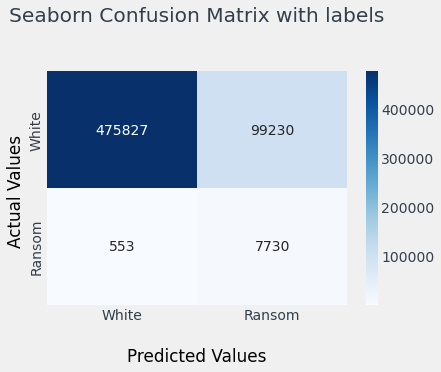

In [200]:
visualise_confusion_matrix(y_test, y_pred_dl_bin)

## 6.0 Comparison with stock data
To understand if our data-cleaning and feature engineering has helped get better performance from our models, we compare the results with our original unprocessed data.

In [132]:
X_train_stock.head()

,year,day,length,weight,count,looped,neighbors,income
2264511,2017,43,0,0.500000,1,0,2,31515644.0
1289376,2014,163,4,0.040000,1,0,2,100000000.0
1046802,2013,286,2,0.500000,1,0,1,81050000.0
2335966,2017,115,92,1.016858,72,0,2,100030000.0
1214724,2014,89,144,0.028767,1189,1187,4,184953990.0


In [128]:
#Stock data
#X_train_stock is not processed.
MLP_model.fit(X_train_stock, y_train)
MLP_dirty_preds = MLP_model.predict(X_test_stock)

In [186]:
#printing table
result4_table.add_row([
    'MLP dirty',
    np.round(accuracy_score(y_true = y_test, y_pred = MLP_dirty_preds), 2),
    np.round(f1_score(y_true = y_test, y_pred = MLP_dirty_preds), 2),
    np.round(precision_score(y_true = y_test, y_pred = MLP_dirty_preds),2),
    np.round(recall_score(y_true = y_test, y_pred = MLP_dirty_preds),2),
    np.round(log_loss(y_true = y_test, y_pred = MLP_dirty_preds), 2)
])
print(result4_table)

C:\Users\tnezhad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+----------+----------+-----------+--------+----------+
|  Model Name  | Accuracy | F1-Score | Precision | Recall | Log-loss |
+--------------+----------+----------+-----------+--------+----------+
|   lr_model   |   0.75   |   0.07   |    0.04   |  0.63  |   8.59   |
|  SVC_model   |   0.87   |   0.11   |    0.06   |  0.55  |   4.46   |
|   rf_model   |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
|  gbdt_model  |   0.93   |   0.28   |    0.17   |  0.95  |   2.34   |
| stacking_clf |   0.99   |   0.73   |    0.87   |  0.63  |   0.23   |
|  MLP_model   |   0.99   |   0.43   |    0.72   |  0.31  |   0.4    |
|   DL_model   |   0.83   |   0.13   |    0.07   |  0.93  |   5.91   |
|  MLP dirty   |   0.99   |   0.0    |    0.0    |  0.0   |   0.49   |
+--------------+----------+----------+-----------+--------+----------+


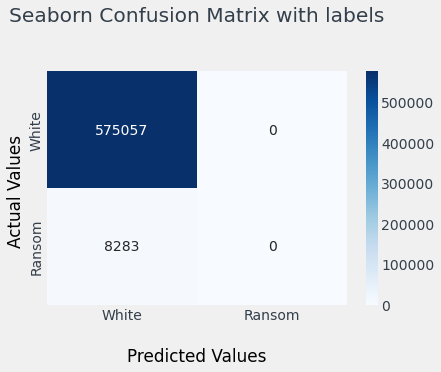

In [130]:
visualise_confusion_matrix(y_test, MLP_dirty_preds)

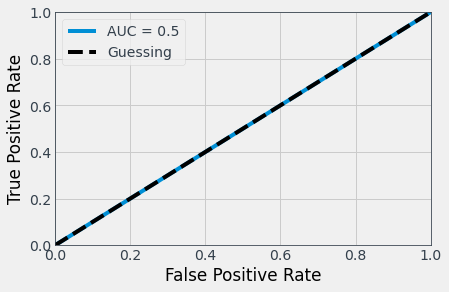

{'fpr': array([0., 1.]), 'tpr': array([0., 1.]), 'threshold': array([1., 0.])}

In [131]:
y_pred_proba_dirty = MLP_model.predict_proba(X_test_stock)
plot_roc_curve(y_pred_proba_dirty[:, 1], y_test, show_graph=True)

Our engineered features and cleansed data have indeed increased the performace of our model
We see a substantial increase all the metrics in our models.